In [ ]:
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import mse
import matplotlib.pyplot as plt

In [209]:
base_vars = pd.read_csv("base_variables.csv.gz")
base_vars

,id,eom,excntry,gvkey,permno,prc_local,ret_exc,ret_exc_lead1m,me,be_me,ope_be,at_gr1,ret_3_1
0,10000.0,1986-01-31,USA,13007.0,10000.0,4.375000,NaN,-0.262439,16.100000,NaN,NaN,NaN,NaN
1,10000.0,1986-02-28,USA,13007.0,10000.0,3.250000,-0.262439,0.359422,11.960000,NaN,NaN,NaN,NaN
2,10000.0,1986-03-31,USA,13007.0,10000.0,4.437500,0.359422,-0.103933,16.330000,NaN,NaN,NaN,-0.257143
3,10000.0,1986-04-30,USA,13007.0,10000.0,4.000000,-0.103933,-0.227590,15.172000,NaN,NaN,NaN,0.014286
4,10000.0,1986-05-31,USA,13007.0,10000.0,3.109375,-0.227590,-0.010271,11.793859,0.058420,-0.763425,NaN,0.230769
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784833,135628901.0,2024-01-31,USA,356289.0,NaN,6.355000,NaN,NaN,170.676235,0.082321,-0.120398,NaN,NaN
2784834,135628901.0,2024-02-29,USA,356289.0,NaN,5.000000,NaN,NaN,134.285000,0.104630,-0.120398,NaN,NaN
2784835,135628901.0,2024-03-31,USA,356289.0,NaN,5.290000,NaN,NaN,143.549440,0.097878,-0.120398,NaN,NaN
2784836,135628901.0,2025-01-31,USA,356289.0,NaN,2.720000,NaN,NaN,84.325440,0.536583,-0.009943,5.006107,NaN


In [56]:
macro_vars = pd.read_csv("macro_variables.csv.gz")
macro_vars

,date,DGS10,T10Y2Y,FEDFUNDS,UNRATE
0,1985-01-31,11.17,1.27,8.35,7.3
1,1985-02-28,11.91,1.25,8.50,7.2
2,1985-03-31,11.65,1.22,8.58,7.2
3,1985-04-30,11.41,1.50,8.27,7.3
4,1985-05-31,10.28,1.36,7.97,7.2
...,...,...,...,...,...
486,2025-07-31,4.37,0.43,4.33,4.2
487,2025-08-31,4.23,0.64,4.33,4.3
488,2025-09-30,4.16,0.56,4.22,NaN
489,2025-10-31,4.11,0.51,4.09,NaN


In [158]:
## Fama French portfolios - for market return and model risk-factor decomposition (if wanted)
FF_portfolios = pd.read_csv("F-F_Research_Data_5_Factors_2x3.csv", skiprows = 4, nrows=747)
FF_portfolios['date'] = pd.to_datetime(FF_portfolios['date'].astype(str), format='%Y%m')
FF_portfolios['date'] = FF_portfolios['date'].dt.to_period('M').dt.to_timestamp('M').dt.strftime('%Y-%m-%d')
FF_portfolios


,date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,1963-07-31,-0.39,-0.48,-0.81,0.64,-1.15,0.27
1,1963-08-31,5.08,-0.80,1.70,0.40,-0.38,0.25
2,1963-09-30,-1.57,-0.43,0.00,-0.78,0.15,0.27
3,1963-10-31,2.54,-1.34,-0.04,2.79,-2.25,0.29
4,1963-11-30,-0.86,-0.85,1.73,-0.43,2.27,0.27
...,...,...,...,...,...,...,...
742,2025-05-31,6.06,-0.72,-2.88,1.29,2.51,0.38
743,2025-06-30,4.86,-0.02,-1.60,-3.20,1.45,0.34
744,2025-07-31,1.98,-0.15,-1.27,-0.29,-2.08,0.34
745,2025-08-31,1.85,4.88,4.42,-0.68,2.07,0.38


In [210]:
data_full = base_vars.merge(macro_vars, left_on='eom', right_on='date')
data_full = data_full[data_full['prc_local']>1]

train = data_full[data_full['date']<'2010-01-01']
test = data_full[data_full['date']>='2010-01-01']


In [62]:
## Run modified FF for one stock
simple = ols("ret_exc_lead1m ~ me + be_me + ope_be + at_gr1 + ret_3_1", data = train).fit()
print(simple.summary())

                            OLS Regression Results                            
Dep. Variable:         ret_exc_lead1m   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     550.8
Date:                Sun, 16 Nov 2025   Prob (F-statistic):               0.00
Time:                        15:55:41   Log-Likelihood:             1.9544e+05
No. Observations:             1396515   AIC:                        -3.909e+05
Df Residuals:                 1396509   BIC:                        -3.908e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0031      0.000     15.558      0.0

In [68]:
test['y_hat'] = simple.predict(test[['me', 'be_me', 'ope_be', 'at_gr1', 'ret_3_1']])
test[['ret_exc_lead1m', 'y_hat']]

C:\Users\biorio\AppData\Local\Temp\ipykernel_20560\2038384632.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['y_hat'] = simple.predict(test[['me', 'be_me', 'ope_be', 'at_gr1', 'ret_3_1']])


,ret_exc_lead1m,y_hat
305,-0.000666,0.006690
306,0.020575,0.006708
307,0.124274,0.006646
308,0.004717,0.005694
309,-0.043548,0.005694
...,...,...
2784833,NaN,NaN
2784834,NaN,NaN
2784835,NaN,NaN
2784836,NaN,NaN


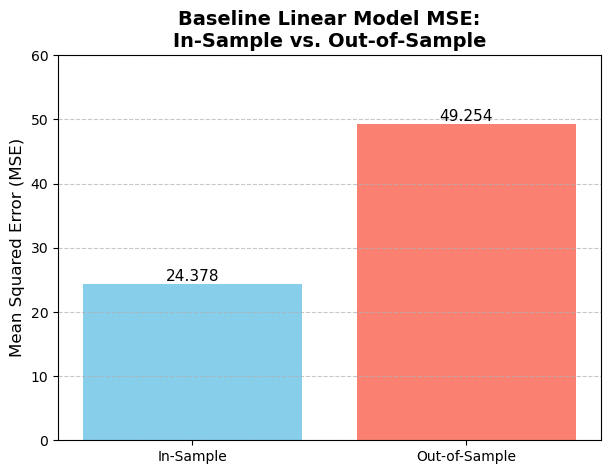

In [ ]:
fin = test[['ret_exc_lead1m', 'y_hat']].dropna()

in_out = ['In-Sample', 'Out-of-Sample']
mses = [simple.mse_model, mse(fin['ret_exc_lead1m'], fin['y_hat'])]

plt.figure(figsize=(7, 5))
bars = plt.bar(in_out, mses, color=['skyblue', 'salmon'])

# Add labels above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom', fontsize=11)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.title('Baseline Linear Model MSE:\nIn-Sample vs. Out-of-Sample', fontsize=14, fontweight='bold')
plt.ylim(0, 60)

plt.savefig('baseline_mse.png')

In [ ]:
fin['top_decile'] = fin['y_hat'] > fin['y_hat'].quantile(0.9)
fin['bot_decile'] = fin['y_hat'] < fin['y_hat'].quantile(0.1)
fin



np.float64(0.006381232288395169)

In [175]:
## Now what we do is re-calculate the model each time step, 
#     go long the stocks with the highest expected return and short the stocks with the lowest (top 10% and lowest 10% respectively).
#     report the model MSE, realized MSE, and the return of this strategy\
import statsmodels.api as sm
from dateutil.relativedelta import relativedelta

In [178]:
pd.set_option('mode.chained_assignment', None) 

In [211]:
## start with 10 years of data then roll forward

data_full['date'] = pd.to_datetime(data_full['date'])
step_forward_dates = data_full['date'].sort_values().unique()[120:]

results_dataframe = pd.DataFrame(columns=['date', 'train_mse', 'test_mse', 'ls_return'])

for d in step_forward_dates:
    d_minus_10 = d - relativedelta(years=10)

    train_d = data_full[(data_full['date']>=d_minus_10) & (data_full['date']<d)]
    test_d = data_full[data_full['date']==d]
    baseline = ols("ret_exc_lead1m ~ me + be_me + ope_be + at_gr1 + ret_3_1", data = train_d).fit()
    
    test_d['y_hat'] = baseline.predict(exog = test_d[['me', 'be_me', 'ope_be', 'at_gr1', 'ret_3_1']])

    fin = test_d[['ret_exc_lead1m', 'y_hat']].dropna()
    
    fin['top_decile'] = fin['y_hat'] > fin['y_hat'].quantile(0.9)
    fin['bot_decile'] = fin['y_hat'] < fin['y_hat'].quantile(0.1)

    ls_return = fin[fin['top_decile']]['ret_exc_lead1m'].mean() - fin[fin['bot_decile']]['ret_exc_lead1m'].mean()

    results_dataframe.loc[len(results_dataframe)] = [d, baseline.mse_resid, mse(fin['ret_exc_lead1m'], fin['y_hat']), ls_return]
    
results_dataframe['cum_ret'] = (1 + results_dataframe['ls_return']).cumprod() - 1
results_dataframe


c:\Users\biorio\AppData\Local\anaconda3\envs\myenv\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\biorio\AppData\Local\anaconda3\envs\myenv\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\biorio\AppData\Local\anaconda3\envs\myenv\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\biorio\AppData\Local\anaconda3\envs\myenv\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\biorio\AppData\Local\anaconda3\envs\myenv\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\biorio\AppData\Local\anaconda3\en

,date,train_mse,test_mse,ls_return,cum_ret
0,1995-01-31,0.021599,0.018236,0.019123,0.019123
1,1995-02-28,0.021587,0.019672,-0.012835,0.006042
2,1995-03-31,0.021599,0.019648,0.036558,0.042821
3,1995-04-30,0.021646,0.023507,0.034807,0.079118
4,1995-05-31,0.021711,0.029455,-0.047801,0.027535
...,...,...,...,...,...
357,2024-10-31,0.037452,0.258584,0.032780,7.099753
358,2024-11-30,0.039495,0.047714,0.047652,7.485721
359,2024-12-31,0.039711,NaN,NaN,NaN
360,2025-01-31,0.039881,NaN,NaN,NaN


In [212]:
results_dataframe['date'] = pd.to_datetime(results_dataframe['date'])
FF_portfolios['date'] = pd.to_datetime(FF_portfolios['date'])

FF_port_sub = FF_portfolios[FF_portfolios['date'].isin(results_dataframe['date'])]
FF_port_sub['mkt_cumulative'] = (1 + FF_port_sub['Mkt-RF']/100).cumprod() - 1

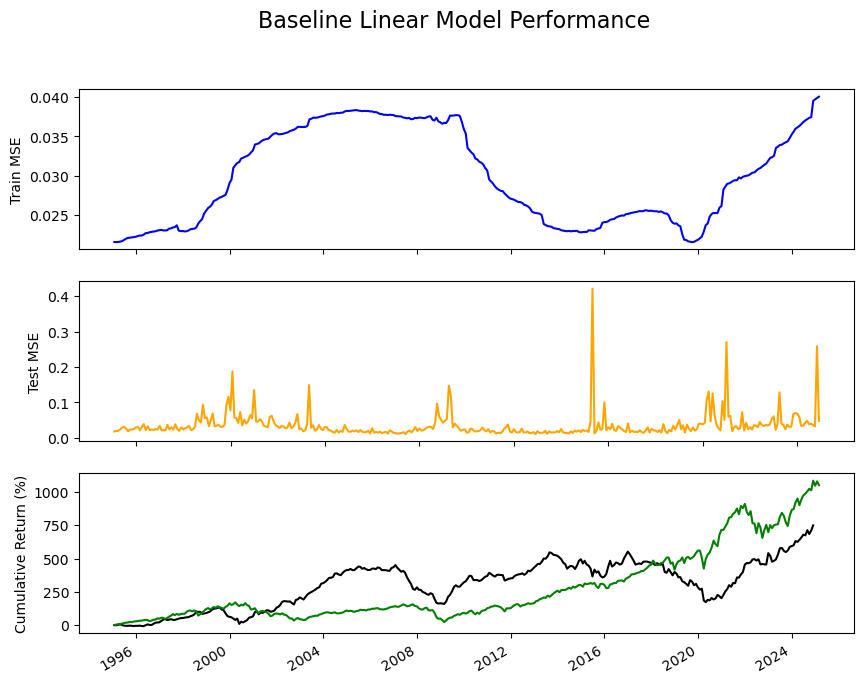

In [213]:
from datetime import datetime

N = 12

fig, axes = plt.subplots(3, figsize=(10, 8), sharex=False)
axes[0].plot(results_dataframe['date'], results_dataframe['train_mse'], color = 'blue')
axes[0].set_ylabel('Train MSE')
axes[1].plot(results_dataframe['date'], results_dataframe['test_mse'], color = 'orange')
axes[1].set_ylabel('Test MSE')
axes[2].plot(results_dataframe['date'], results_dataframe['cum_ret']*100, color = 'black')
axes[2].plot(FF_port_sub['date'], FF_port_sub['mkt_cumulative']*100, color = 'green')
axes[2].set_ylabel('Cumulative Return (%)')

fig.autofmt_xdate()
fig.suptitle('Baseline Linear Model Performance', fontsize=16)
plt.show()

In [224]:
## sharp ratio
print(f"Model SR: {results_dataframe['ls_return'].mean()/results_dataframe['ls_return'].std()}")
print(f"Market SR: {FF_port_sub['Mkt-RF'].mean()/FF_port_sub['Mkt-RF'].std()}")

Model SR: 0.14631877254199746
Market SR: 0.1726885374217898


In [208]:
#results_dataframe.sort_values('ls_return',ascending=False)
data_full.sort_values('ret_exc_lead1m',ascending=False)

,id,eom,excntry,gvkey,permno,ret_exc,ret_exc_lead1m,me,be_me,ope_be,at_gr1,ret_3_1,date,DGS10,T10Y2Y,FEDFUNDS,UNRATE
2748776,111278001.0,2003-12-31,USA,112780.0,NaN,-1.000766,15348.999304,0.000172,NaN,NaN,NaN,0.000000,2003-12-31,4.27,2.43,0.98,5.7
2780786,118516401.0,2015-01-31,USA,185164.0,NaN,-0.999806,5480.171569,0.143388,5146.963084,-0.054826,-0.147508,-0.003879,2015-01-31,1.68,1.21,0.11,5.7
2748001,111158101.0,2003-09-30,USA,111581.0,NaN,-0.975865,3048.999300,0.000168,3657.957245,-0.186688,-0.455987,NaN,2003-09-30,3.96,2.46,1.01,6.1
2749981,111555401.0,1999-05-31,USA,115554.0,NaN,-0.511400,1027.221708,0.936944,NaN,NaN,NaN,NaN,1999-05-31,5.64,0.22,4.74,4.2
2759585,114968301.0,2003-02-28,USA,149683.0,NaN,-0.000871,1013.998980,0.052930,NaN,NaN,NaN,0.000000,2003-02-28,3.71,2.18,1.26,5.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784833,135628901.0,2024-01-31,USA,356289.0,NaN,NaN,NaN,170.676235,0.082321,-0.120398,NaN,NaN,2024-01-31,3.99,-0.28,5.33,3.7
2784834,135628901.0,2024-02-29,USA,356289.0,NaN,NaN,NaN,134.285000,0.104630,-0.120398,NaN,NaN,2024-02-29,4.25,-0.39,5.33,3.9
2784835,135628901.0,2024-03-31,USA,356289.0,NaN,NaN,NaN,143.549440,0.097878,-0.120398,NaN,NaN,2024-03-31,4.20,-0.39,5.33,3.9
2784836,135628901.0,2025-01-31,USA,356289.0,NaN,NaN,NaN,84.325440,0.536583,-0.009943,5.006107,NaN,2025-01-31,4.58,0.36,4.33,4.0
